In [46]:
# -------------------
# Import libraries
# -------------------

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib 
matplotlib.use("nbagg")

In [55]:
# --------------------------
# Parameters configuration
# --------------------------

# Spatial
nx = 500            # Number of grid in x-direction
nz = 500            # Number of grid in z-direction
nptx = nx + 1       # Number of grid points in x-direction
nptz = nz + 1       # Number of grid points in z-direction
dx   = 1./2           # Grid point distance in x-direction
dz   = 1./2           # Grid point distance in z-direction
xmax = nx * dx
zmax = nz * dz

# Temporal
nt   = 702          # Maximum number of time steps
dt   = 0.0010 / 2       # Time step

# Source
f0   = 50.          # Dominant frequency of the source (Hz)
t0   = 2. / f0      # Dource time shift
sx  = 250           # Dource location in grid in x-direction
sz  = 250           # Dource location in grid in z-direction

# Medium
c0   = 580.         # wave velocity in medium (m/s)
rho = 1000.         # Density of the medium(kg/m3)
kapa = rho * c0**2 # Bulk modulus

In [48]:
# -------------------------
# CFL stability criterion
# -------------------------

cfl = c0 * dt / np.sqrt((dx ** 2 + dz ** 2) / 2) # CFL number
print('CFL number is', cfl,", it should be no more than 1")

CFL number is 0.58 , it should be no more than 1


In [49]:
# ---------------------
# Point source
# ---------------------

time = np.arange(nt + 1) * dt
src = -8. * (time - t0) * f0 * (np.exp(-1.0 * (4*f0) ** 2 * (time - t0) ** 2)) # Gaussian
#tmp = np.pi ** 2 * f0 **2 * (time - t0) ** 2
# src = (1 - 2 * tmp) * np.exp(-tmp) # Ricker

<IPython.core.display.Javascript object>


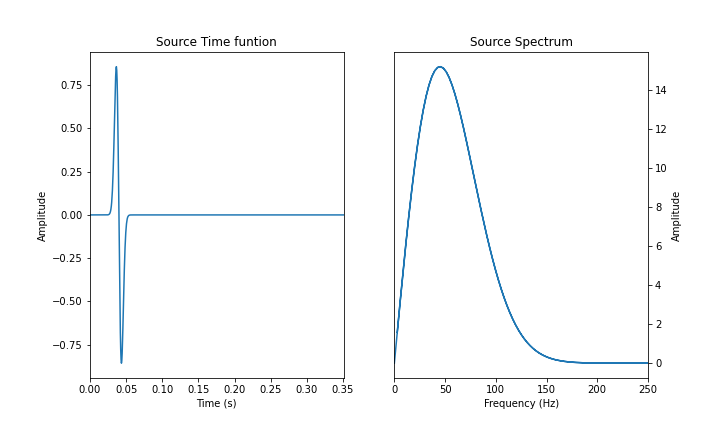

In [50]:
# --------------------------
# Plot source time function
# --------------------------


fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# Source time funtion
ax1.plot(time, src)
ax1.set_title('Source Time funtion')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Source spectrum
spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt ) # time domain to frequency domain
ax2.plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax2.set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

In [51]:
# Number of grid points per wavelength
l = c0 / f0
ngpw = int(l / dx) + 1
print("The dominant wavelenght is about %.3f, and number of grid points per wavelength is about %d" % (l_min, ngpw))

The minmum wavelenght is about 7.733, and number of grid points per wavelength is about 24


<IPython.core.display.Javascript object>


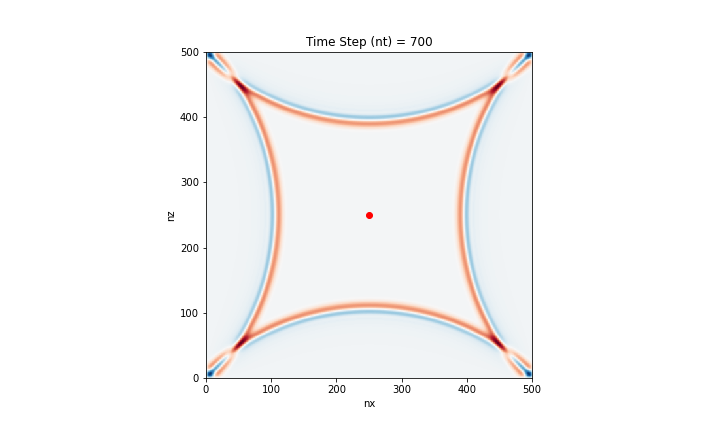

In [53]:
# --------------------------------------
# 2d acoustic wave propagation and plot
# --------------------------------------

# Initialize empty pressure and derivatives
d2px = np.zeros((nptz, nptx))
d2pz = np.zeros((nptz, nptx))
pnow = np.zeros((nptz, nptx))
pold = np.zeros((nptz, nptx))
pnew = np.zeros((nptz, nptx))


plt.ion()
fig2,  ax3 = plt.subplots(figsize=(10, 6))
ax3.plot(sx, sz, marker='o', color='red')
ax3.set_title('Time Step')
ax3.set_xlim(0, nx)
ax3.set_ylim(0, nz)
ax3.set_xlabel('nx')
ax3.set_ylabel('nz')
plt.show()


for n in range(1, nt):
    for i in range(1, nx):
        d2px[:, i] = (pnow[:, i - 1] - 2 * pnow[:, i] + pnow[:, i + 1]) / dx ** 2
    for j in range(1, nz):
        d2pz[j, :] = (pnow[j - 1, :] - 2 * pnow[j, :] + pnow[j + 1, :]) / dz ** 2
        
    # Time extrapolation
    pnew = 2 * pnow - pold + (c0 ** 2) * dt ** 2 * (d2pz + d2px)
    
    # Inject source
    pnew[sz, sx] = pnew[sz, sx] + src[n] / (dx * dz) * (dt ** 2) 
    
    pold, pnow = pnow, pnew

    # plot
    if (n % 5) == 0:
        ax3.set_title('Time Step (nt) = %d' % n)
        ax3.imshow(pnew, interpolation="nearest", cmap=plt.cm.RdBu)
        plt.gcf().canvas.draw()

<IPython.core.display.Javascript object>


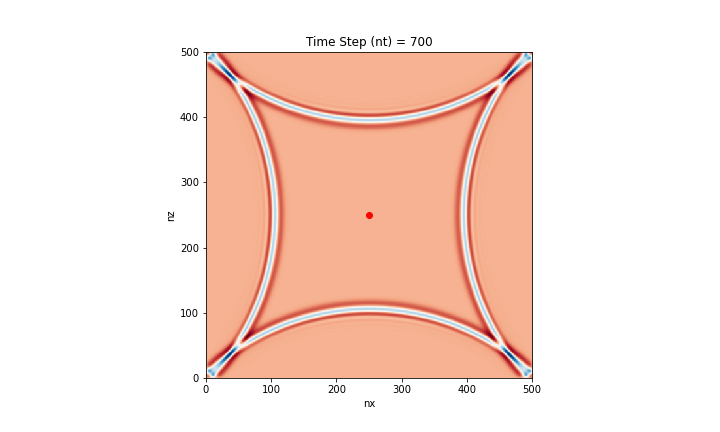

In [54]:
# ---------------------------------------------
# Finite difference method with stagerred grid
# ---------------------------------------------


# Initialize
unew = np.zeros((nptz - 2, nptx - 1))
u = np.zeros((nptz - 2, nptx - 1))
vnew = np.zeros((nptz - 1, nptx - 2))
v = np.zeros((nptz - 1, nptx - 2))
pnew = np.zeros((nptz, nptx))
p = np.zeros((nptz, nptx))
             
dpx = np.zeros(u.shape)
dpz = np.zeros(v.shape)
dux = np.zeros((nptz, nptx))
dvz = np.zeros((nptz, nptx))

plt.ion()
fig3, ax4 = plt.subplots(figsize=(10, 6))
ax4.plot(sx, sz, marker='o', color='red')
ax4.set_title('Time Step')
ax4.set_xlim(0, nx)
ax4.set_ylim(0, nz)
ax4.set_xlabel('nx')
ax4.set_ylabel('nz')
plt.show()

for n in range(nt):
    for i in range(1, nx):
        dux[1:nz, i] = (u[:, i] - u[:, i - 1]) / dx
    for j in range(1, nz):
        dvz[j, 1:nx] = (v[j, :] - v[j - 1, :]) / dz
    pnew = p - dt * kapa * (dux + dvz)
             
    # Inject source
    pnew[sz, sx] = pnew[sz, sx] + src[n] / (dx * dz) * (dt ** 2) 
    p = pnew
             
    for i in range(nx):
        dpx[:, i] = (p[1:nz, i + 1] - p[1:nz, i]) / dx
    for j in range(nz):
        dpz[j, :] = (p[j + 1, 1:nx] - p[j, 1:nx]) / dz
             
    unew = u - (dt / rho) * dpx
    vnew = v - (dt / rho) * dpz
    
    u = unew
    v = vnew
        
    # plot
    if (n % 5) == 0:
        ax4.set_title('Time Step (nt) = %d' % n)
        ax4.imshow(p, interpolation="nearest", cmap=plt.cm.RdBu)
        plt.gcf().canvas.draw()

In [66]:
# -------------------------
# Perfectly Matched Layer
# -------------------------

nxp = int(nx / 10) # Number of grid in each PML in x-direction
nzp = int(nz / 10) # Number of grid in each PML in z-direction
delta_x = nxp * dx # Width of each PML in x-direction
delta_z = nzp * dz # Width of each PML in z-direction
nxc = nx + 2*nxp   # Number of grid in computational domian in x-direction
nzc = nz + 2*nzp   # Number of grid in computational domain in z-direction
nptxc = nxc + 1
nptzc = nzc + 1

# Dampling parameter
R = 0.001 # Reflection coefficient
sigmax0 = np.log(1 / R) * 3 * c0 / (2 * delta_x)
sigmaz0 = np.log(1 / R) * 3 * c0 / (2 * delta_z)

def sigmax(x):
    if 0 < x < xmax:
        return 0
    elif x >= xmax:
        return sigmax0 * (x - xmax) ** 2 / delta_x ** 2
    else:
        return sigmax0 * x ** 2 / delta_x ** 2
    
def sigmaz(z):
    if 0 < z < zmax:
        return 0
    elif z >= zmax:
        return sigmaz0 * (z - zmax) ** 2 / delta_z ** 2
    else:
        return sigmaz0 * z ** 2 / delta_z ** 2

In [67]:
xu = np.arange(nxc) * dx + dx/2 - dx * nxp
sxu = np.array(list(map(sigmax, xu)))
sxu = np.matmul(np.ones((nptzc - 2, 1)), sxu.reshape(1, -1))

xp = np.arange(nptxc) * dx - dx * nxp
sxp = np.array(list(map(sigmax, xp)))
sxp = np.matmul(np.ones((nptzc, 1)), sxp.reshape(1, -1))

zv = np.arange(nzc) * dz + dz/2 - dz * nzp
szv = np.array(list(map(sigmaz, zv)))
szv = np.matmul(szv.reshape(-1, 1), np.ones((1, nptxc - 2)))

zp = np.arange(nptzc) * dz - dz * nzp
szp = np.array(list(map(sigmaz, zp)))
szp = np.matmul(szp.reshape(-1, 1), np.ones((1, nptxc)))

<IPython.core.display.Javascript object>


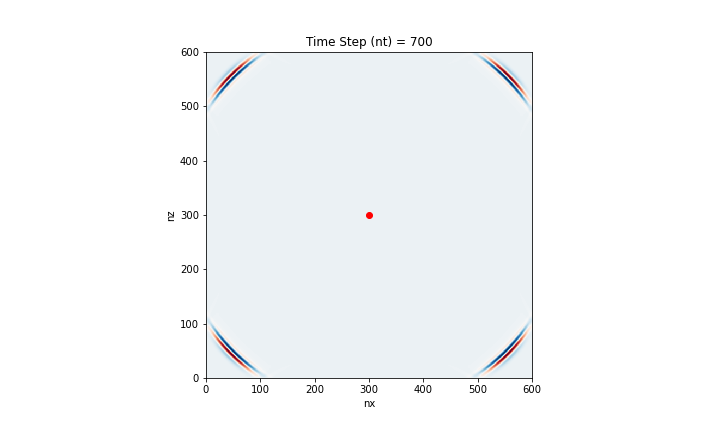

In [78]:

# Initialize
unew = np.zeros((nptzc - 2, nptxc - 1))
u = np.zeros((nptzc - 2, nptxc - 1))
vnew = np.zeros((nptzc - 1, nptxc - 2))
v = np.zeros((nptzc - 1, nptxc - 2))
pnew = np.zeros((nptzc, nptxc))
p = np.zeros((nptzc, nptxc))
pxnew = np.zeros((nptzc, nptxc))
px = np.zeros((nptzc, nptxc))
pznew = np.zeros((nptzc, nptxc))
pz = np.zeros((nptzc, nptxc))  
              
dpx = np.zeros(u.shape)
dpz = np.zeros(v.shape)
dux = np.zeros((nptzc, nptxc))
dvz = np.zeros((nptzc, nptxc))

sx = nptxc // 2
sz = nptzc // 2
plt.ion()
fig4, ax5 = plt.subplots(figsize=(10, 6))
ax5.plot(sx, sz, marker='o', color='red')
ax5.set_title('Time Step')
ax5.set_xlim(0, nxc)
ax5.set_ylim(0, nzc)
ax5.set_xlabel('nx')
ax5.set_ylabel('nz')
plt.show()

for n in range(nt):
    for i in range(1, nxc):
        dux[1:nzc, i] = (u[:, i] - u[:, i - 1]) / dx
    for j in range(1, nzc):
        dvz[j, 1:nxc] = (v[j, :] - v[j - 1, :]) / dz
    pxnew = px - dt * sxp * px - dt * kapa * dux
    pznew = pz - dt * szp * pz - dt * kapa * dvz
    pnew = pxnew + pznew
             
    # Inject source
    pnew[sz, sx] = pnew[sz, sx] + src[n] / (dx * dz) * (dt ** 2) 
    p = pnew
    px = pxnew
    pz = pznew
             
    for i in range(nxc):
        dpx[:, i] = (p[1:nzc, i + 1] - p[1:nzc, i]) / dx
    for j in range(nzc):
        dpz[j, :] = (p[j + 1, 1:nxc] - p[j, 1:nxc]) / dz
             
    unew = u - (dt / rho) * dpx - dt * sxu * u
    vnew = v - (dt / rho) * dpz - dt * szv * v
    
    u = unew
    v = vnew
        
    # plot
    if (n % 5) == 0:
        ax5.set_title('Time Step (nt) = %d' % n)
        ax5.imshow(p, interpolation="nearest", cmap=plt.cm.RdBu)
        plt.gcf().canvas.draw()